In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from conico import *
import time



%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
assert (1 + find_eps() == 1)
assert not (1 + find_eps()+1e-10 == 1)
print('numerical precision of float sum ~', find_eps())
EPS = find_eps()

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


In [11]:
def subopt_metric(z, res):
    return np.linalg.norm(res) / (1. + np.linalg.norm(z))

def compare(dim_dict, scs_presolve_iters = 1000, scs_presolve_eps = 1e-16, max_lsqr_iters=500,
            conico_scs_time_ratio = 1., verbose=True, **generate_opts):
        
    A, b, c, x_true, s_true, y_true = generate_problem(dim_dict, **generate_opts)

    scs_opts = {'verbose':verbose}
    if scs_presolve_eps is not None:
        scs_opts['eps'] = scs_presolve_eps
    if scs_presolve_iters is not None:
        scs_opts['max_iters'] = scs_presolve_iters

    start = time.time()
    z_con, info = solve(A,b,c,dim_dict, verbose=verbose,
                              max_lsqr_iters=max_lsqr_iters,
                              refine_solver_time_ratio=conico_scs_time_ratio,
                             solver_options=scs_opts, return_z=True)
    #print(info)
    conico_time = time.time() - start
    #u,v = xsy2uv(x_con, s_con, y_con)
    res, u,v, _ = residual_and_uv(z_con,A,b,c,dim2cones(dim_dict))

    conico_subopt = subopt_metric(z_con, res)

    k = info['iter']
    scs_subopt = None

    while k < 25000:

        k *= 2
        start = time.time()
        z_scs, info = scs_solve(A, b, c, dim_dict, verbose=verbose, max_iters = k, eps=1e-16)
        scs_time = time.time() - start

        res, u,v, _ = residual_and_uv(z_scs,A,b,c,dim2cones(dim_dict))

        if scs_subopt is None:
            scs_subopt = subopt_metric(z_scs, res)
        else:
            scs_subopt = min(scs_subopt, subopt_metric(z_scs, res))

        if scs_time > conico_time:
            break
    if conico_time > scs_time:
        return np.nan, np.nan, conico_time, scs_time

    assert scs_time > conico_time
    
    return conico_subopt, scs_subopt, conico_time, scs_time

In [12]:
N_repeats = 10

long_scs_run = 5000
short_scs_run = 1000

experiments = [
    ## dims, options
    
    # socp
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                             'mode':'solvable', 'nondiff_point':False, 'density':.3, 'random_scale_max':10}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                             'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':10}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':40}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':40}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':2}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':short_scs_run*3, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':2}],
    
    # sdp
    [{'l':10, 's':[5]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                             'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':10}],
    [{'l':10, 's':[5]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                             'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':10}],
    [{'l':10, 's':[5]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':40}],
    [{'l':10, 's':[10]*3}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':40}],
    [{'l':10, 's':[10]*3}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':False, 'density':.1, 'random_scale_max':2}],
    [{'l':10, 's':[10]*3}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'solvable', 'nondiff_point':True, 'density':.3, 'random_scale_max':2}],
    
    # infeas/unbound
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'infeasible', 'nondiff_point':False, 'density':.3, 'random_scale_max':40}],
    #[{'l':10, 'q':[10]*20}, {'scs_presolve_iters':short_scs_run*2, 'scs_presolve_eps':1e-11,
    #                     'mode':'unbounded', 'nondiff_point':False, 'density':.2, 'random_scale_max':2}],
    [{'l':10, 'q':[10]*10}, {'scs_presolve_iters':short_scs_run, 'scs_presolve_eps':1e-11,
                         'mode':'infeasible', 'nondiff_point':False, 'density':.3, 'random_scale_max':2}],
    [{'l':10, 's':[5]*5}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                             'mode':'unbounded', 'nondiff_point':False, 'density':.3, 'random_scale_max':40}],
    [{'l':10, 'q':[5]*5, 's':[5]*5}, {'scs_presolve_iters':long_scs_run, 'scs_presolve_eps':1e-11,
                             'mode':'infeasible', 'nondiff_point':False, 'density':.3, 'random_scale_max':10}],
    
    
]

## Run all experiments 

In [13]:
con_subopts, scs_subopts = [], []

In [14]:
np.random.seed(0)

for experiment in experiments:
    print(experiment)
    for i in range(N_repeats):
        con_subopt, scs_subopt, conico_time, scs_time = compare(experiment[0], 
#                                                             scs_presolve_iters = 5000,
#                                                             scs_presolve_eps = 1e-11,
                                                            verbose=False,
                                                            **experiment[1])
        con_subopts.append(con_subopt)
        scs_subopts.append(scs_subopt)
        print('%.2e, %.2e, %.2f, %.2f' % (con_subopt, scs_subopt, conico_time, scs_time))
    print()

[{'l': 10, 'q': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}, {'scs_presolve_iters': 5000, 'scs_presolve_eps': 1e-11, 'mode': 'solvable', 'nondiff_point': False, 'density': 0.3, 'random_scale_max': 10}]
2.29e-08, 1.11e-05, 0.79, 0.91
6.73e-09, 1.36e-04, 0.75, 0.93
9.62e-08, 3.29e-04, 0.97, 1.11
9.37e-08, 2.24e-04, 1.60, 1.86
1.85e-07, 6.55e-05, 1.59, 1.87
7.84e-08, 8.68e-04, 0.90, 1.10
1.52e-09, 2.53e-04, 0.71, 0.84
1.90e-09, 1.25e-04, 0.69, 0.84
7.03e-10, 8.22e-05, 0.59, 0.84
2.11e-09, 3.92e-04, 0.71, 0.87

[{'l': 10, 'q': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}, {'scs_presolve_iters': 5000, 'scs_presolve_eps': 1e-11, 'mode': 'solvable', 'nondiff_point': True, 'density': 0.3, 'random_scale_max': 10}]
3.50e-15, 2.65e-07, 0.54, 0.84
2.15e-15, 2.52e-06, 0.53, 0.83
1.41e-14, 4.10e-05, 0.57, 0.83
1.61e-14, 4.19e-05, 0.58, 0.83
7.46e-15, 4.96e-05, 0.51, 0.83
7.55e-15, 1.75e-06, 0.49, 0.86
1.38e-14, 1.45e-05, 0.53, 0.85
1.71e-14, 2.18e-05, 0.58, 0.83
1.00e-14, 2.77e-05, 0.51, 0.84
7.67e-15, 6

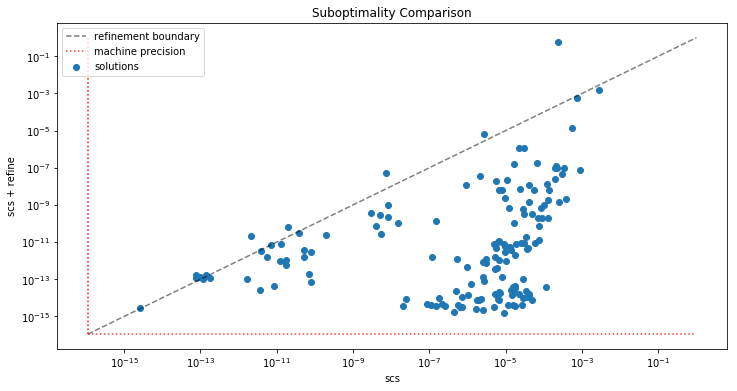

In [16]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

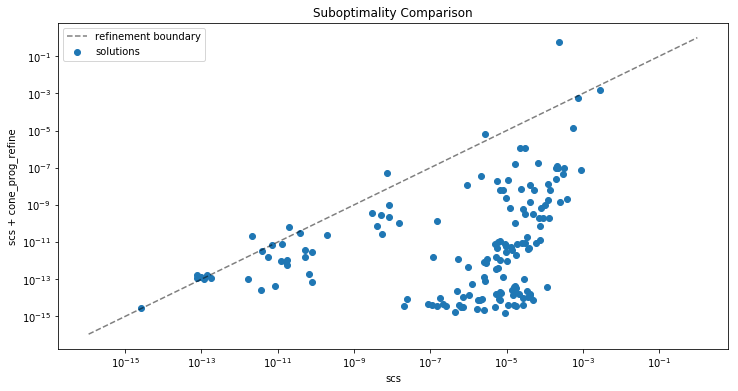

In [20]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + cone_prog_refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
# plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, 1.], 'r:')


plt.legend(loc='upper left')
plt.savefig('comparison.png')

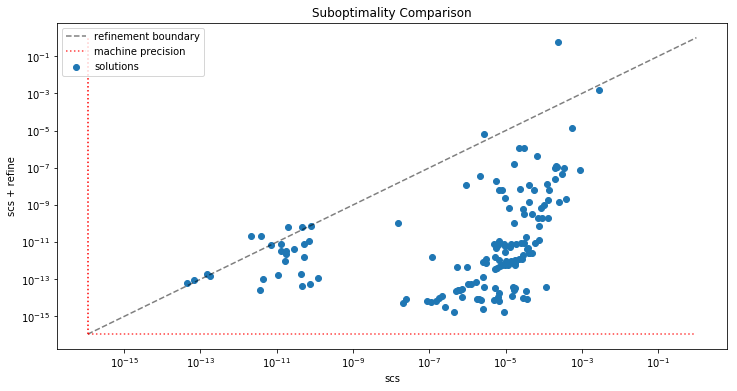

In [7]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

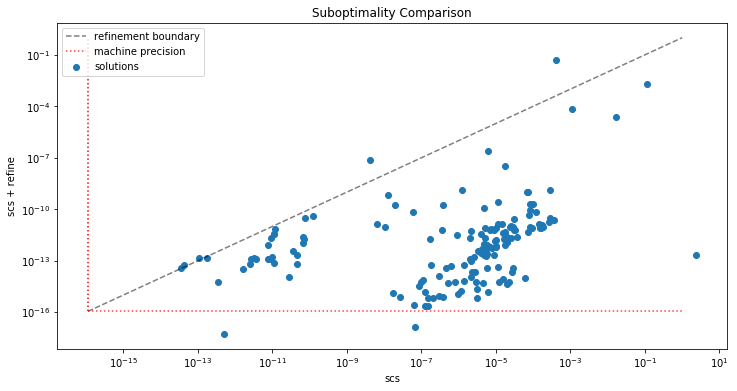

In [16]:
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,1.],[EPS,1.], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1.],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1.], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

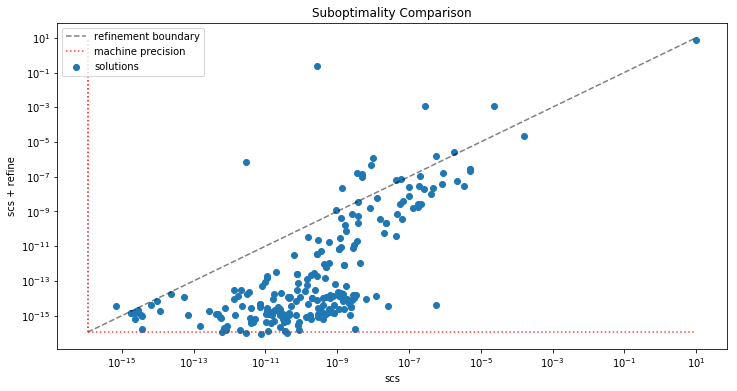

In [86]:
largest = max(max(scs_subopts), max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,largest],[EPS,largest], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,largest],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, largest], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')

## Big-ass SDP 

In [ ]:
# dim_dict = {'s':[100]}

# np.random.seed(0)


# for con_subopt, scs_subopt, conico_time, scs_time in compare(dim_dict, 
#                                                              scs_presolve_iters = 5000,
#                                                              scs_presolve_eps = 1e-11,
#                                                              n_scenarios = 1, 
#                                                              conico_scs_time_ratio=1.,
#                                                              max_lsqr_iters=5000,
#                                                              verbose=True):
#     print()
#     print('%.2e, %.2e, %.2f, %.2f' % (con_subopt, scs_subopt, conico_time, scs_time))
#     print

## SDP GENERATED BY CVXPY

In [79]:
import cvxpy as cvx

def gen_prob(n):
    np.random.seed(100)
    m = (n*4)//5
    Sigma = np.random.randn(m,n)
    Sigma = Sigma.T @ Sigma/n
    x = cvx.Variable(n)
    objective = cvx.Maximize(cvx.sum(x))
    constraints = [x >= 0, cvx.diag(x) << Sigma]
    cvxpy_problem = cvx.Problem(objective, constraints)
    data = cvxpy_problem.get_problem_data('SCS')
    A, b, c, dims = data[0]['A'], data[0]['b'], data[0]['c'], data[0]['dims']
    dims_dict = {}
    dims_dict['l'], dims_dict['s'] = int(dims.nonpos), list([int(el) for el in dims.psd])
    
    return cvxpy_problem, A, b, c, dims_dict

cvxpy_problem, A, b, c, dim_dict = gen_prob(100)


In [78]:
x_con, s_con, y_con, info = solve(A,b,c,dim_dict,
      max_lsqr_iters=100,
      refine_solver_time_ratio=1.,
      verbose=True,
     solver_options={'verbose':True, 'eps':1e-15, 'max_iters':1000})


In [ ]:
cvxpy_problem.solve(verbose=True, solver='SCS', max_iters=5000)


data = cvxpy_problem.get_problem_data('SCS')

A, b, c, dims = data[0]['A'], data[0]['b'], data[0]['c'], data[0]['dims']

A, b, c, dims = data[0]['A'], data[0]['b'], data[0]['c'], data[0]['dims']
dims_dict = {}
dims_dict['l'], dims_dict['s'] = dims.nonpos, dims.psd

## LP 

In [ ]:
dim_dict = {'l':1500}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 1, verbose=True)

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()
plt.savefig('LP_convergence.png')


## SOCP

In [ ]:
dim_dict = {'l':1000, 'q':[10]*100}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 1)

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()
plt.savefig('SOCP_convergence.png')






## SDP 

In [ ]:
dim_dict = {'s':[100]}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 1)



In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()
plt.savefig('SDP_convergence.png')







## Old

In [ ]:
dim_dict = {'l':100, 'q':[10]*10}

conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY, n_scenarios = 20)

plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts, label='solutions')
plt.xlabel('RMSE, scs')
plt.ylabel('RMSE, scs + conico')
plt.plot([EPS,1],[EPS,1], 'k--', label='refinement boundary')
plt.plot([EPS,1],[EPS, EPS], 'r-.', label='machine precision')
plt.plot([EPS,EPS],[EPS, 1], 'r-.')
plt.legend()

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, conico_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
# l: 1000
plt.yscale('log')
plt.xscale('log')
plt.scatter(conico_subopts, scs_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(conico_subopts, scs_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')

In [ ]:
# dim_dict = {'l':100}
# conico_subopts, scs_subopts = simulate_a_bunch_of_problems(dim_dict, SCS_N_ITERS_TO_TRY)

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(conico_subopts, scs_subopts)
plt.plot([1e-16,1],[1e-16,1], 'k--')